In [1]:
import geojson
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sns
from skimage.color import rgb2gray
from skimage import filters, io, feature, morphology
from skimage.measure import regionprops, regionprops_table, find_contours
# from stardist.data import test_image_nuclei_2d, test_image_he_2d
from skimage.morphology import label
from tqdm import tqdm

def load_tif_image(path: str):
    """Loads a .tif image from a given path and returns it as a NumPy array.
    Code from: https://stackoverflow.com/questions/7569553/working-with-tiffs-import-export-in-python-using-numpy

    ### Args:
        - `path (str)`: path of the image
    """
    im = Image.open(path)
    imarray = np.array(im)
    return imarray

def show_image(image: np.ndarray, figsize: tuple = (15, 8), axis: str = "off", title="ROI"):
    """## Visualizes an image

    ### Args:
        - `image (np.ndarray)`: NumPy array representing an image
        - `figsize (tuple, optional)`: width and height of the figure. Defaults to (15, 8).
        - `axis (str, optional)`: whether to include the axis ticks. Defaults to "off".
        - `title (str, optional)`: title of the image. Defaults to \"ROI\".
    """
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis(axis)
    plt.title(title, fontsize=figsize[0])
    plt.show()

# Lambda function to convert 4d image to 3d
convert_4d_to_3d = lambda image: image[:, :, :-1]

def show_regionprops(image: np.ndarray, figsize: tuple = (15, 8), axis: str = "off", title="ROI"):
    """## Visualizes regionprops results on an image

    ### Args:
        - `image (np.ndarray)`: NumPy array representing an image
        - `figsize (tuple, optional)`: width and height of the figure. Defaults to (15, 8).
        - `axis (str, optional)`: whether to include the axis ticks. Defaults to "off".
        - `title (str, optional)`: title of the image. Defaults to \"ROI\".
    """
    # First convert image to grey scale
    if image.ndim == 3:
        image = rgb2gray(image)
    
    # Get edges
    edges = feature.canny(image, sigma=3, low_threshold=image.max()*0.2, high_threshold=image.max()*0.2)
    
    # Show regionprops results on image
    label_image = label(edges)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image, cmap=plt.cm.gray)
    
    for region in regionprops(label_image):
    # Draw rectangle around segmented regions.
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
    
    ax.set_title(title, fontsize=figsize[0])
    ax.axis(axis)
    plt.show()

# Load an image

In [2]:
# Set some constants
IMAGES_DIR = r"01_training_dataset_tif_ROIs" # Images folder
IMAGES_LIST = os.listdir(IMAGES_DIR) # List of image file names
IMAGES_PATHS = [os.path.join(IMAGES_DIR, image) for image in IMAGES_LIST] # Paths to images

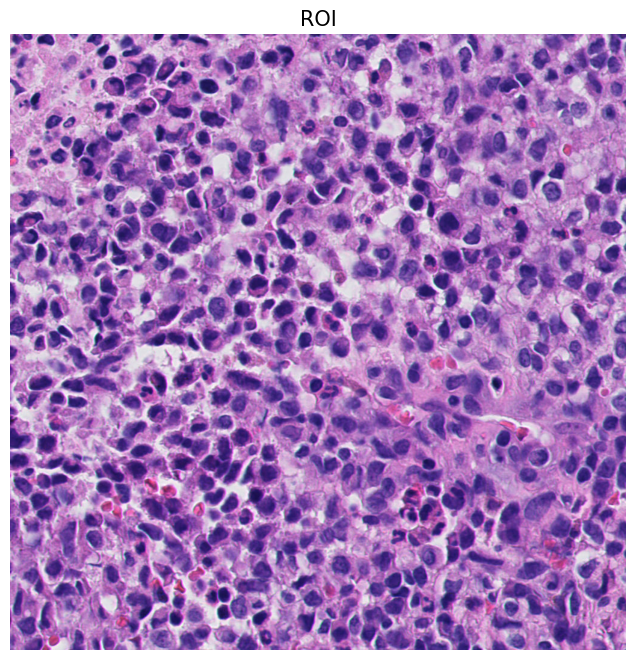

In [3]:
# Load first image
image_0 = load_tif_image(IMAGES_PATHS[0])
show_image(image_0)

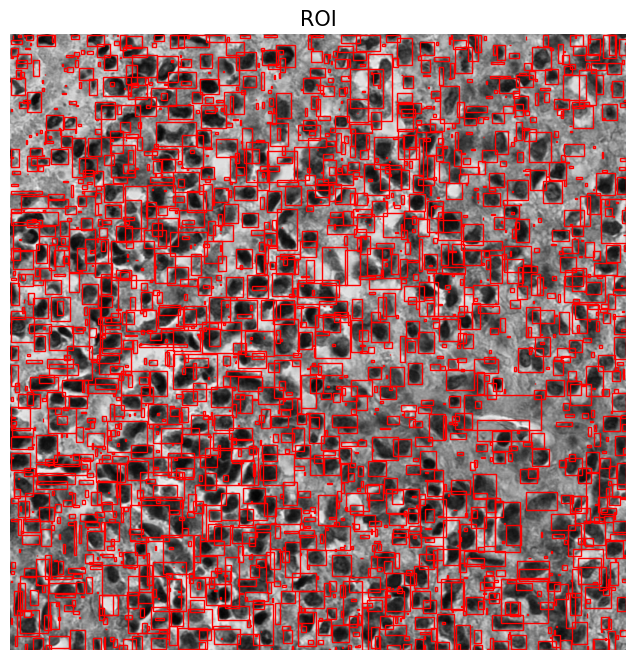

In [4]:
# Example of calling the function
show_regionprops(convert_4d_to_3d(image_0))

# Load a geojson file

In [5]:
GEOJSONS_DIR = r"01_training_dataset_geojson_nuclei"
GEOJSONS_LIST = os.listdir(GEOJSONS_DIR) 
GEOJSONS_PATHS = [os.path.join(GEOJSONS_DIR, image) for image in GEOJSONS_LIST] 

Some functions for loading the data and getting coordinates.

In [6]:
# Function to load geojson file
def load_geojson(path_to_file: str):
    """Loads a geojson file and returns the features
    Code from: https://stackoverflow.com/questions/42753745/how-can-i-parse-geojson-with-python

    ### Args:
        - `path_to_file (str)`: path to GeoJSON file
    """
    with open(path_to_file) as f:
        gj = geojson.load(f)
    features = gj['features']
    return features

# Function to get coordinates
def get_coordinates_from_geometry(geojson_entry: dict):
    """Reads coordinates from a geojson file element

    ### Args:
        - `geojson_entry (dict)`: Entry of a geojson file
    """
    coordinates = geojson_entry["geometry"]["coordinates"]
    coordinates = np.asarray(coordinates).reshape(-1, 2).astype(np.int64)
    return np.asarray(coordinates)

Each geojson file is a list of dictionaries. Each dictionaries is constructed as follows:
- ```{"geometry": {"coordinates": [...], "type": ...}, "properties": {"classification": {"color": [...], "name": ...}, "objectType": "..."}, "type": ...} ```

In [7]:
# Read geojson file
geojson_0 = load_geojson(GEOJSONS_PATHS[0])

# Get coordinates of first entry
coords_0_0 = get_coordinates_from_geometry(geojson_0[0])

Get all different classification types.

In [8]:
classification_names = []
for entry in tqdm(geojson_0):
    name = entry["properties"]["classification"]["name"]
    if name not in classification_names:
        classification_names.append(name)

print(f"classification_names: {classification_names.__str__()[2:-2]}")

100%|██████████| 633/633 [00:00<?, ?it/s]

classification_names: nuclei_tumor', 'nuclei_apoptosis', 'nuclei_lymphocyte', 'nuclei_endothelium


In [9]:
classification_names.__str__()[2:-2]

"nuclei_tumor', 'nuclei_apoptosis', 'nuclei_lymphocyte', 'nuclei_endothelium"

Below, we plot the annotations, giving each classification type a different color.

100%|██████████| 633/633 [00:00<00:00, 4524.11it/s]
C:\Users\BramUser\AppData\Local\Temp\ipykernel_12488\1920504894.py:33: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contour(binary_mask_nuclei_apoptosis, level=[0.5], colors="b", linewidths=2) # Green contour
C:\Users\BramUser\AppData\Local\Temp\ipykernel_12488\1920504894.py:34: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contour(binary_mask_nuclei_lymphocyte, level=[0.5], colors="y", linewidths=2) # Yellow contour
C:\Users\BramUser\AppData\Local\Temp\ipykernel_12488\1920504894.py:35: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contour(binary_mask_nuclei_endothelium, level=[0.5], colors="g", linewidths=2)


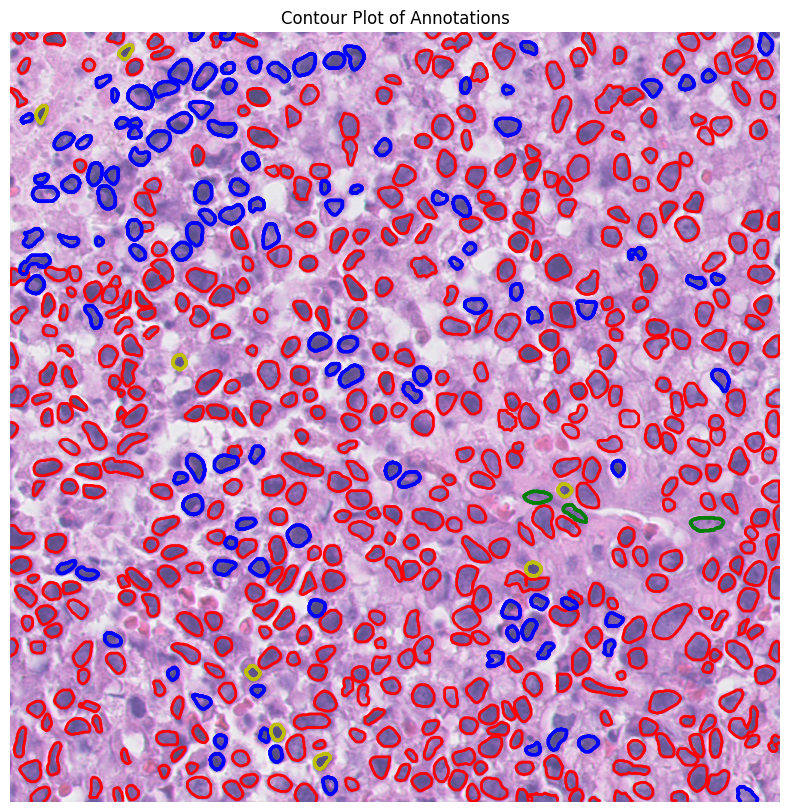

In [10]:
from skimage.draw import polygon

# Create a blank image
image_shape = (1024, 1024)  # Adjust size as needed

# Get binary mask for annotation types
binary_mask_nuclei_tumor = np.zeros(image_shape, dtype=np.int32)
binary_mask_nuclei_apoptosis = np.zeros(image_shape, dtype=np.int32)
binary_mask_nuclei_lymphocyte = np.zeros(image_shape, dtype=np.int32)
binary_mask_nuclei_endothelium = np.zeros(image_shape, dtype=np.int32)

# Create a contour plot
plt.figure(figsize=(10, 10))
# plt.imshow(image_0, cmap='gray', alpha=0.5)
plt.imshow(image_0, alpha=0.75)
for entry in tqdm(geojson_0):
    try:
        coords = get_coordinates_from_geometry(entry)
        name = entry["properties"]["classification"]["name"]
        rr, cc = polygon(coords[:, 1], coords[:, 0], shape=image_shape)
        if name == "nuclei_tumor":
            # Fill the binary mask with the polygon
            binary_mask_nuclei_tumor[rr, cc] = 1
        elif name == "nuclei_apoptosis":
            binary_mask_nuclei_apoptosis[rr, cc] = 1
        elif name == "nuclei_lymphocyte":
            binary_mask_nuclei_lymphocyte[rr, cc] = 1
        elif name == "nuclei_endothelium":
            binary_mask_nuclei_endothelium[rr, cc] = 1
    except:
        pass
plt.contour(binary_mask_nuclei_tumor, levels=[0.5], colors='r', linewidths=2)  # Red contour
plt.contour(binary_mask_nuclei_apoptosis, level=[0.5], colors="b", linewidths=2) # Green contour
plt.contour(binary_mask_nuclei_lymphocyte, level=[0.5], colors="y", linewidths=2) # Yellow contour
plt.contour(binary_mask_nuclei_endothelium, level=[0.5], colors="g", linewidths=2)
plt.title("Contour Plot of Annotations")
plt.axis('off')
plt.show()

Combine all masks as one binary mask.

In [11]:
# Lambda function to combine binary masks
from functools import reduce
def combine_binary_masks(*binary_masks):
    binary_mask = reduce(lambda bm1, bm2: np.logical_or(bm1, bm2), binary_masks)
    return binary_mask

C:\Users\BramUser\AppData\Local\Temp\ipykernel_12488\961896284.py:14: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contour(binary_mask, level=[0.5], colors="black", linewidths=2)


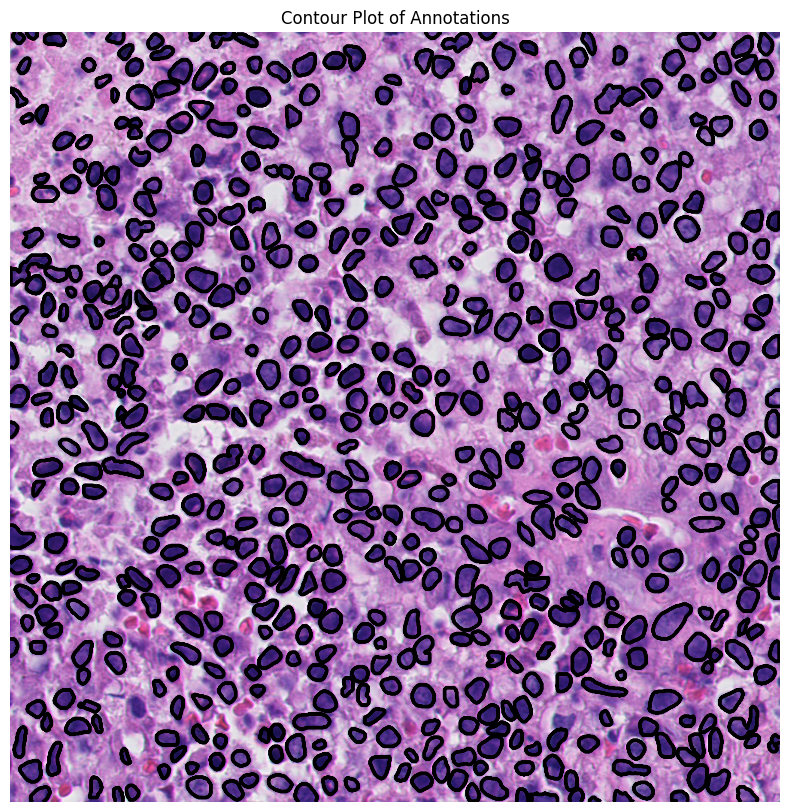

In [12]:
# np.logical_or(binary_mask_nuclei_tumor, binary_mask_nuclei_apoptosis).astype(np.int32)
binary_mask = \
    combine_binary_masks(
        binary_mask_nuclei_tumor, 
        binary_mask_nuclei_apoptosis, 
        binary_mask_nuclei_lymphocyte, 
        binary_mask_nuclei_endothelium
    )\
        .astype(np.int32)

# Create a contour plot
plt.figure(figsize=(10, 10))
plt.imshow(image_0)
plt.contour(binary_mask, level=[0.5], colors="black", linewidths=2)
plt.title("Contour Plot of Annotations")
plt.axis("off")
plt.show()

# Regionprops

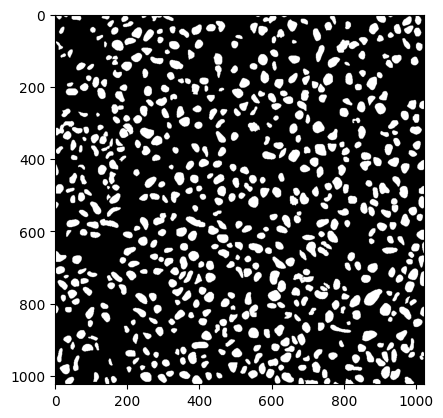

In [13]:
import math
from skimage.measure import label, regionprops, regionprops_table
"""Code from https://scikit-image.org/docs/0.24.x/auto_examples/segmentation/plot_regionprops.html"""

label_img = label(binary_mask)
regions = regionprops(label_img)

fig, ax = plt.subplots()
ax.imshow(binary_mask, cmap=plt.cm.gray)
plt.show()

Get table of regionprops

In [14]:
props = regionprops_table(
    label_img,
    properties=('centroid', 'orientation', 'axis_major_length', 'axis_minor_length'),
)

pd.DataFrame(props)

centroid-0  centroid-1  orientation  axis_major_length  \
0       6.801282   10.583333     0.764745          16.063605   
1       3.295918   29.214286     1.387999          14.265656   
2       6.582375  140.708812    -1.482611          22.237518   
3       4.195804  246.608392    -1.252930          17.687135   
4       7.288690  280.187500    -1.185982          34.073614   
..           ...         ...          ...                ...   
604  1015.961864  752.983051    -0.882985          19.252386   
605  1017.813559  813.059322     1.304177          24.295337   
606  1016.842742  890.125000     1.422678          22.423812   
607  1018.430636  709.280347     1.527171          39.262261   
608  1021.160714  776.446429     1.436388          13.425954   

     axis_minor_length  
0            12.505885  
1             9.217783  
2            15.344224  
3            11.287108  
4            15.594489  
..                 ...  
604          15.854074  
605          13.734976  
606          14.301293  
607          11.800186  
608           6.011798  

[609 rows x 5 columns]

In [15]:
"""Obtained from https://github.com/scikit-image/scikit-image/blob/main/skimage/measure/_regionprops.py"""

COL_DTYPES = {
    'area': float,
    'area_bbox': float,
    'area_convex': float,
    'area_filled': float,
    'axis_major_length': float,
    'axis_minor_length': float,
    'bbox': int,
    'centroid': float,
    'centroid_local': float,
    'centroid_weighted': float,
    'centroid_weighted_local': float,
    'coords': object,
    'coords_scaled': object,
    'eccentricity': float,
    'equivalent_diameter_area': float,
    'euler_number': int,
    'extent': float,
    'feret_diameter_max': float,
    'image': object,
    'image_convex': object,
    'image_filled': object,
    'image_intensity': object,
    'inertia_tensor': float,
    'inertia_tensor_eigvals': float,
    'intensity_max': float,
    'intensity_mean': float,
    'intensity_min': float,
    'intensity_std': float,
    'label': int,
    'moments': float,
    'moments_central': float,
    'moments_hu': float,
    'moments_normalized': float,
    'moments_weighted': float,
    'moments_weighted_central': float,
    'moments_weighted_hu': float,
    'moments_weighted_normalized': float,
    'num_pixels': int,
    'orientation': float,
    'perimeter': float,
    'perimeter_crofton': float,
    'slice': object,
    'solidity': float,
}

In [16]:
props = regionprops_table(
    label_img,
    properties=('label', 'area', 'centroid', 'orientation', 'axis_major_length', 'axis_minor_length', 'perimeter', 'coords'),
)

# Add aspect_ratio
props["aspect_ratio"] = props["axis_major_length"] / props["axis_minor_length"]

pd.DataFrame(props)

label   area   centroid-0  centroid-1  orientation  axis_major_length  \
0        1  156.0     6.801282   10.583333     0.764745          16.063605   
1        2   98.0     3.295918   29.214286     1.387999          14.265656   
2        3  261.0     6.582375  140.708812    -1.482611          22.237518   
3        4  143.0     4.195804  246.608392    -1.252930          17.687135   
4        5  336.0     7.288690  280.187500    -1.185982          34.073614   
..     ...    ...          ...         ...          ...                ...   
604    605  236.0  1015.961864  752.983051    -0.882985          19.252386   
605    606  236.0  1017.813559  813.059322     1.304177          24.295337   
606    607  248.0  1016.842742  890.125000     1.422678          22.423812   
607    608  346.0  1018.430636  709.280347     1.527171          39.262261   
608    609   56.0  1021.160714  776.446429     1.436388          13.425954   

     axis_minor_length  perimeter  \
0            12.505885  44.870058   
1             9.217783  37.313708   
2            15.344224  60.627417   
3            11.287108  48.935029   
4            15.594489  91.355339   
..                 ...        ...   
604          15.854074  56.041631   
605          13.734976  67.213203   
606          14.301293  58.970563   
607          11.800186  91.556349   
608           6.011798  29.899495   

                                                coords  aspect_ratio  
0    [[0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [1, ...      1.284484  
1    [[0, 22], [0, 23], [0, 24], [0, 25], [0, 26], ...      1.547623  
2    [[0, 135], [0, 136], [0, 137], [0, 138], [0, 1...      1.449244  
3    [[0, 239], [0, 240], [0, 241], [0, 242], [0, 2...      1.567021  
4    [[0, 281], [0, 282], [0, 283], [0, 287], [0, 2...      2.184978  
..                                                 ...           ...  
604  [[1007, 754], [1007, 755], [1007, 756], [1008,...      1.214350  
605  [[1009, 806], [1009, 807], [1010, 806], [1010,...      1.768866  
606  [[1010, 887], [1010, 888], [1010, 889], [1010,...      1.567957  
607  [[1012, 700], [1012, 711], [1013, 698], [1013,...      3.327258  
608  [[1018, 774], [1018, 775], [1018, 776], [1018,...      2.233268  

[609 rows x 10 columns]

# Regionprops for individual masks

Now, we will get regionprops from individual masks.

In [17]:
# Function to get regionprops from individual masks
def regionprops_from_mask(
    binary_mask: np.ndarray,
    classification_name: str = "",
    start_label: int = 0) -> pd.DataFrame:
    """Computes regionprops for a binary mask.

    ### Args:
        - `binary_mask (np.ndarray)`: binary 2D NumPy array
        - `classification_name (str, optional)`: name of classification type, ignored if empty string. Defaults to "".
        - `start_label (int, optional)`: number to add to segmented label indices. Defaults to 0.

    ### Returns:
        - `pd.DataFrame`: table containing region properties extracted from binary mask
    """
    # Get connected components & regionprops
    label_img = label(binary_mask)
    # props_image = regionprops(label_img)
    
    # Get regionprops
    props = regionprops_table(
        label_img,
        properties=('label', 'area', 'centroid', 'orientation', 'axis_major_length', 'axis_minor_length', 'perimeter', 'coords'),
    )
    
    # Extract contours for each region
    contours = []
    # for index in range(1, label_img.max()):
    #     label_i = props_image[index].label
    #     contour = find_contours(label_img == label_i, 0.5)[0]
    #     print(contour)
    #     contours.append(contour)
    for index in range(1, label_img.max()+1):
        idx = np.argwhere(props["label"] == index)[0][0]
        coords = props['coords'][idx]
        rr, cc = polygon(coords[:, 1], coords[:, 0])
        contours.append(np.asarray(list(zip(rr, cc))).astype(int).tolist())
    props['contours'] = contours
    
    # Add aspect_ratio & standardized cell shape index
    props["aspect_ratio"] = props["axis_major_length"] / props["axis_minor_length"]
    props["cell_shape_index"] = props["perimeter"] / np.sqrt(props["area"])
    props["cell_shape_index_stand"] = (props["cell_shape_index"] - props["cell_shape_index"].mean()) / props["cell_shape_index"].std()
    del props["cell_shape_index"]
    
    # Add info about classification type if provided
    if not(classification_name == ""):
        props["classification_name"] = [classification_name] * len(props["label"])
    
    # Increment label if start_label > 0
    if start_label > 0:
        props["label"] = props["label"] + start_label
    
    return pd.DataFrame(props)

# nuclei_tumor
nuclei_tumor_props = \
    regionprops_from_mask(
        binary_mask_nuclei_tumor, 
        "nuclei_tumor"
    )

# nuclei_apoptosis
nulcei_apoptosis_props = \
    regionprops_from_mask(
        binary_mask_nuclei_apoptosis, 
        "nuclei_apoptosis", 
        nuclei_tumor_props["label"].max()
    )

# nuclei_lymphocyte
nuclei_lymphocyte_props = \
    regionprops_from_mask(
        binary_mask_nuclei_lymphocyte,
        "nuclei_lymphocyte",
        nulcei_apoptosis_props["label"].max()
    )
    
# nuclei_endothelium
nuclei_endothelium_props = \
    regionprops_from_mask(
        binary_mask_nuclei_endothelium,
        "nuclei_endothelium",
        nuclei_lymphocyte_props["label"].max()
    )

# Concatenate
nuclei_props = \
    pd.concat(
        [
            nuclei_tumor_props,
            nulcei_apoptosis_props,
            nuclei_lymphocyte_props,
            nuclei_endothelium_props,
        ]
    )
nuclei_props

label   area  centroid-0  centroid-1  orientation  axis_major_length  \
0       1  156.0    6.801282   10.583333     0.764745          16.063605   
1       2   98.0    3.295918   29.214286     1.387999          14.265656   
2       3  261.0    6.582375  140.708812    -1.482611          22.237518   
3       4  109.0    2.798165  561.633028    -1.536031          17.836529   
4       5  134.0    3.231343  634.126866    -1.541853          19.359410   
..    ...    ...         ...         ...          ...                ...   
6     609  278.0  930.679856  354.928058     0.231419          21.296214   
7     610  283.0  968.809187  414.240283    -0.812227          23.923281   
0     611  409.0  618.036675  700.980440     1.563655          35.015136   
1     612  333.0  639.312312  750.420420     0.982779          36.312224   
2     613  596.0  653.624161  926.055369    -1.539843          43.505953   

    axis_minor_length   perimeter  \
0           12.505885   44.870058   
1            9.217783   37.313708   
2           15.344224   60.627417   
3            8.528763   42.935029   
4            9.499930   47.556349   
..                ...         ...   
6           16.636627   60.284271   
7           15.399302   63.355339   
0           14.897388   83.698485   
1           12.144799   84.219300   
2           17.635671  103.597980   

                                               coords  \
0   [[0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [1, ...   
1   [[0, 22], [0, 23], [0, 24], [0, 25], [0, 26], ...   
2   [[0, 135], [0, 136], [0, 137], [0, 138], [0, 1...   
3   [[0, 553], [0, 554], [0, 555], [0, 556], [0, 5...   
4   [[0, 625], [0, 626], [0, 627], [0, 628], [0, 6...   
..                                                ...   
6   [[921, 351], [921, 352], [921, 353], [921, 354...   
7   [[960, 416], [960, 417], [960, 418], [960, 419...   
0   [[611, 694], [611, 695], [611, 696], [611, 697...   
1   [[629, 740], [629, 741], [629, 742], [629, 743...   
2   [[646, 916], [646, 917], [646, 918], [646, 919...   

                                             contours  aspect_ratio  \
0   [[4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [5, 2...      1.284484   
1   [[22, 0], [22, 1], [23, 0], [23, 1], [23, 2], ...      1.547623   
2   [[129, 8], [129, 9], [130, 6], [130, 7], [130,...      1.449244   
3   [[553, 0], [553, 1], [554, 0], [554, 1], [554,...      2.091338   
4   [[625, 0], [625, 1], [625, 2], [626, 0], [626,...      2.037848   
..                                                ...           ...   
6   [[347, 926], [347, 927], [347, 928], [347, 929...      1.280080   
7   [[405, 968], [405, 969], [405, 970], [405, 971...      1.553530   
0   [[684, 616], [684, 617], [684, 618], [685, 615...      2.350421   
1   [[736, 632], [736, 633], [736, 634], [736, 635...      2.989940   
2   [[905, 651], [905, 652], [905, 653], [906, 650...      2.466929   

    cell_shape_index_stand classification_name  
0                -0.824221        nuclei_tumor  
1                -0.298885        nuclei_tumor  
2                -0.347952        nuclei_tumor  
3                 0.720964        nuclei_tumor  
4                 0.708521        nuclei_tumor  
..                     ...                 ...  
6                -0.658813   nuclei_lymphocyte  
7                 0.554147   nuclei_lymphocyte  
0                -0.947980  nuclei_endothelium  
1                 1.382836  nuclei_endothelium  
2                -0.434856  nuclei_endothelium  

[613 rows x 13 columns]

Visualize the relationship between cell shape index and aspect ratio.

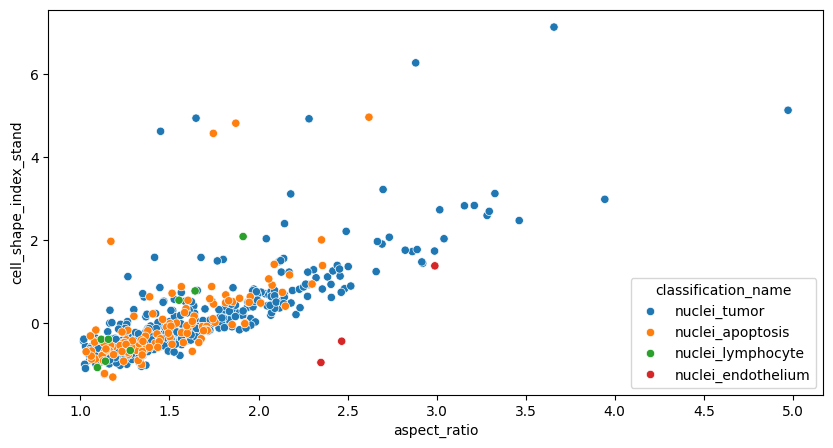

In [18]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=nuclei_props, x="aspect_ratio", y="cell_shape_index_stand", hue="classification_name")
plt.show()

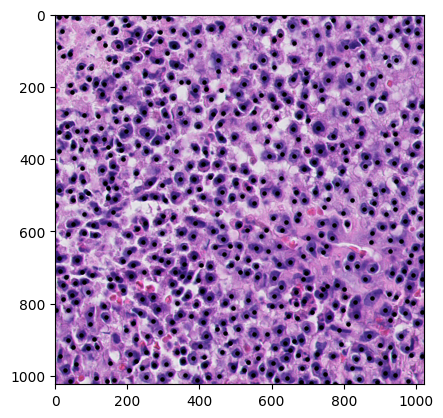

In [19]:
image_zeros = np.zeros((1024, 1024))
# for x, y in zip(nuclei_props['centroid-0'], nuclei_props['centroid-1']):
#     image_zeros[math.ceil(x), math.ceil(y)] = 1
    
plt.imshow(image_0)
plt.scatter(np.ceil(nuclei_props['centroid-1']).astype(int), np.ceil(nuclei_props['centroid-0']).astype(int), s=5, color='black')


C:\Users\BramUser\AppData\Local\Temp\ipykernel_12488\3332385722.py:18: UserWarning: The following kwargs were not used by contour: 'level'
  plt.contour(binary_mask, level=[0.5], colors="gold", linewidths=1)


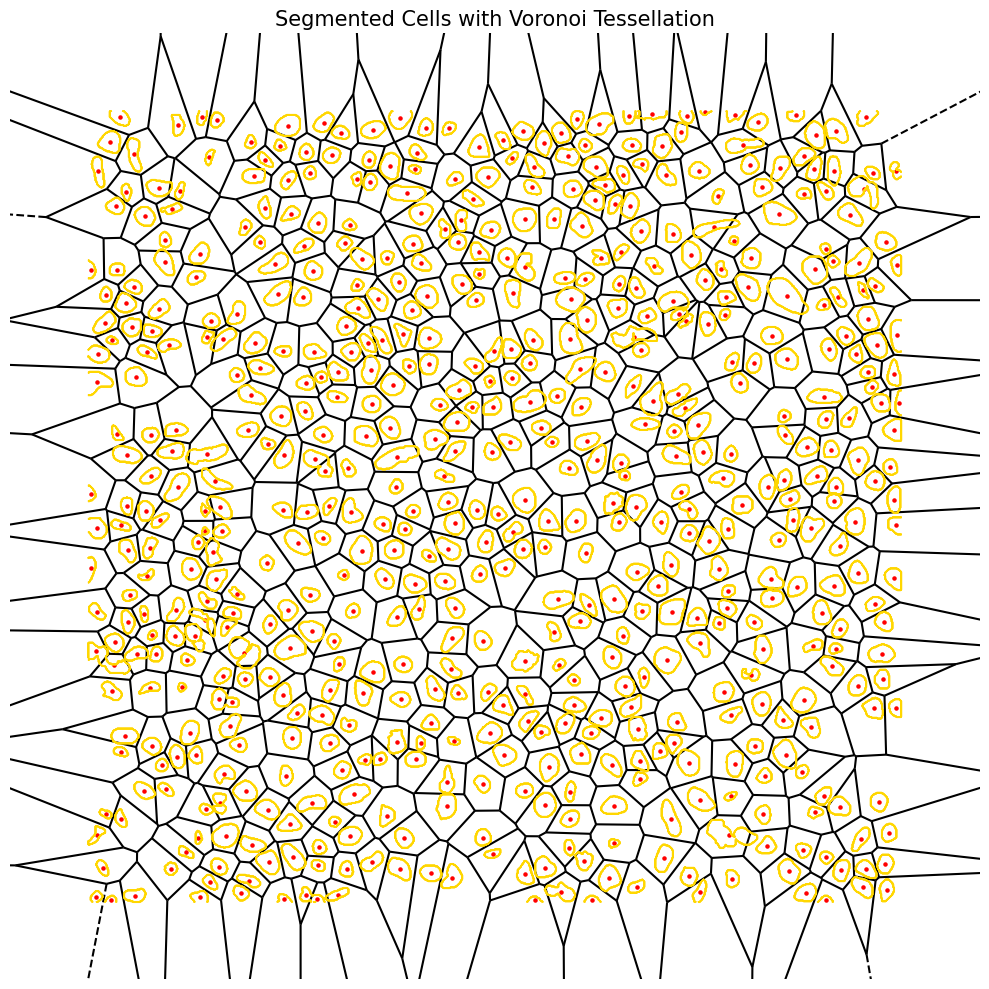

In [20]:
from scipy.spatial import Voronoi, voronoi_plot_2d

nuclei_centroids = nuclei_props.loc[:, ['centroid-0', 'centroid-1']].values

# Perform Voronoi tessellation using centroids
vor = Voronoi(nuclei_centroids[:, ::-1])  # Flip (row, col) to (x, y) for Voronoi

# Plot the result
plt.figure(figsize=(10, 10))
# plt.imshow(image_0, cmap="gray", alpha=0.75)  # Show background image

# Plot Voronoi cells
voronoi_plot_2d(vor, show_vertices=False, line_colors="black", line_width=1.5, show_points=False, ax=plt.gca())

# Plot nuclei centroids
plt.scatter(nuclei_centroids[:, 1], nuclei_centroids[:, 0], color="red", s=5, label="Nuclei Centroids")

plt.contour(binary_mask, level=[0.5], colors="gold", linewidths=1)

# Add title and labels
plt.title("Segmented Cells with Voronoi Tessellation", fontsize=15)
plt.axis("off")
plt.tight_layout()
plt.show()

Compute distance map

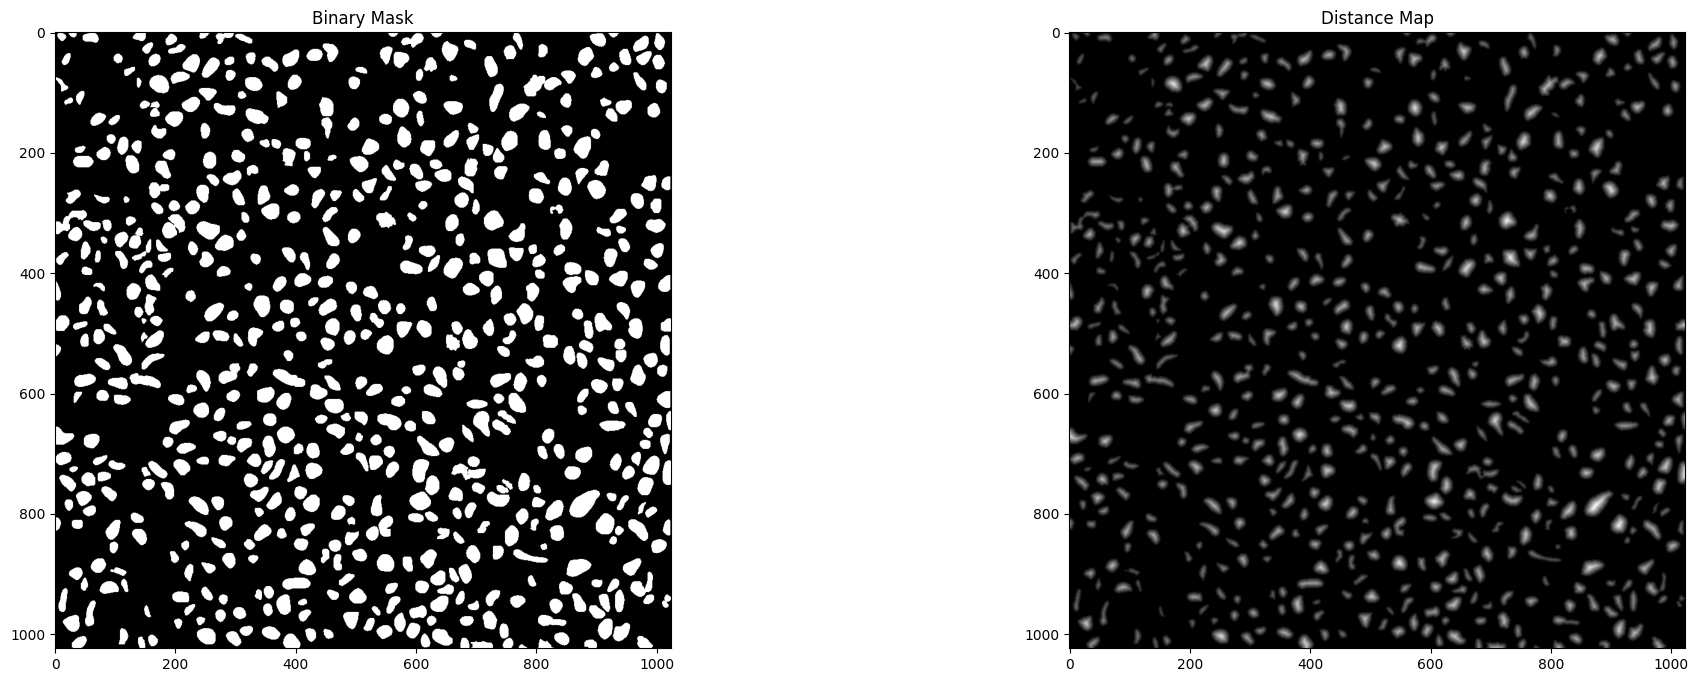

In [21]:
from scipy.ndimage import distance_transform_edt

distance_map = distance_transform_edt(binary_mask)

# Plot
fig, axes = plt.subplots(figsize=(24, 8), nrows=1, ncols=2)

# Plot binary mask
axes[0].imshow(binary_mask, cmap="grey")
axes[0].set_title("Binary Mask")

# Plot distance map
axes[1].imshow(distance_map, cmap="grey")
axes[1].set_title("Distance Map")

plt.show()

In [22]:
from napari_segment_blobs_and_things_with_membranes import voronoi_otsu_labeling, \
                                                           seeded_watershed, \
                                                           local_minima_seeded_watershed
from skimage.io import imread
from skimage.filters import gaussian
from skimage import data

# Get labeled nuclei
labeled_nuclei = voronoi_otsu_labeling(binary_mask, spot_sigma=0, outline_sigma=4)

# Get labeled cells
labeled_cells = seeded_watershed(binary_mask, labeled_nuclei)

c:\Users\BramUser\AppData\Local\Programs\Python\Python311\Lib\site-packages\napari_tools_menu\__init__.py:10: UserWarning: Importing QT failed; now introducing dummy definitions of QMenu class and register_function decorator.
  warnings.warn("Importing QT failed; now introducing dummy definitions of QMenu class and register_function decorator.")


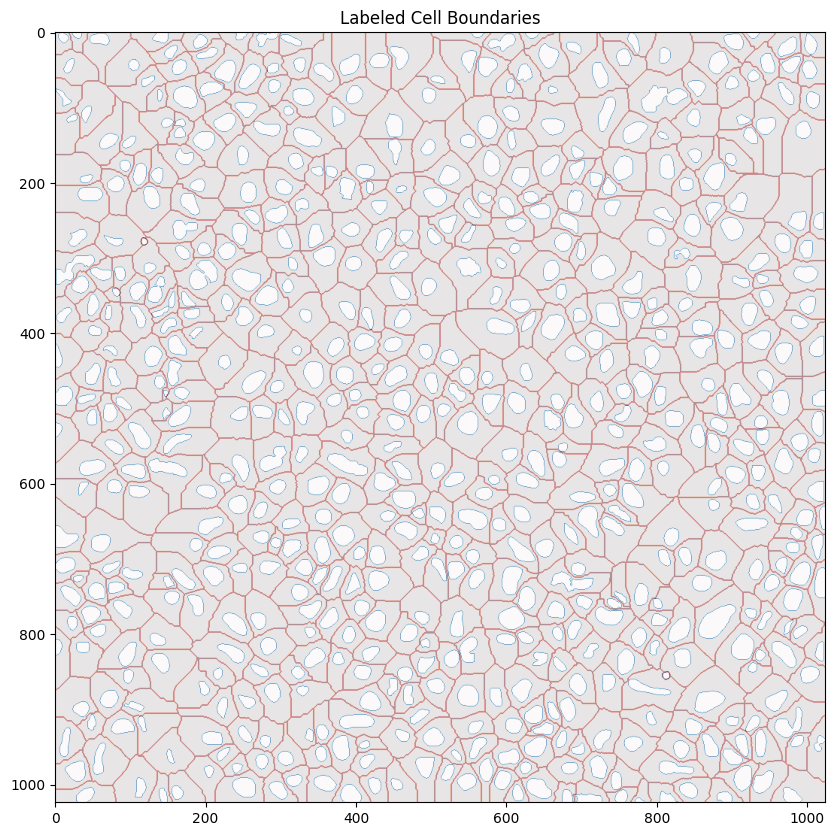

In [23]:
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
import numpy as np

# Find the boundaries of labeled cells
cell_boundaries = find_boundaries(labeled_cells, mode='inner')

# Plot the original binary mask
plt.figure(figsize=(10, 10))
plt.imshow(binary_mask, cmap="gray", alpha=0.5)  # Display the binary mask as background

# Overlay the cell boundaries in red
plt.imshow(cell_boundaries, cmap="Reds", alpha=0.7)

# Optional: Add boundaries for nuclei (if needed)
nuclei_boundaries = find_boundaries(binary_mask, mode='inner')
plt.imshow(nuclei_boundaries, cmap="Blues", alpha=0.5)

# Add title and remove axes
plt.title("Labeled Cell Boundaries")
# plt.axis("off")
plt.show()


# Full pipeline for image to grid transformation

In [106]:
import nuclei_and_cell_segmentation
import importlib
importlib.reload(nuclei_and_cell_segmentation)
import nuclei_and_cell_segmentation as nc_seg

# Get index
index = 121

# Get path
image, geojson_contents = nc_seg.load_tif_image(IMAGES_PATHS[index]), nc_seg.load_geojson(GEOJSONS_PATHS[index])
image = nc_seg.convert_4d_to_3d(image)

labeled_nuclei_array, labeled_cells_array = nc_seg.tif_and_geojson_to_segmentation(
    IMAGES_PATHS[index],
    GEOJSONS_PATHS[index]
)

print(labeled_nuclei_array.max())
print(labeled_cells_array.max())

100%|██████████| 512/512 [00:00<00:00, 3010.64it/s]


408
408


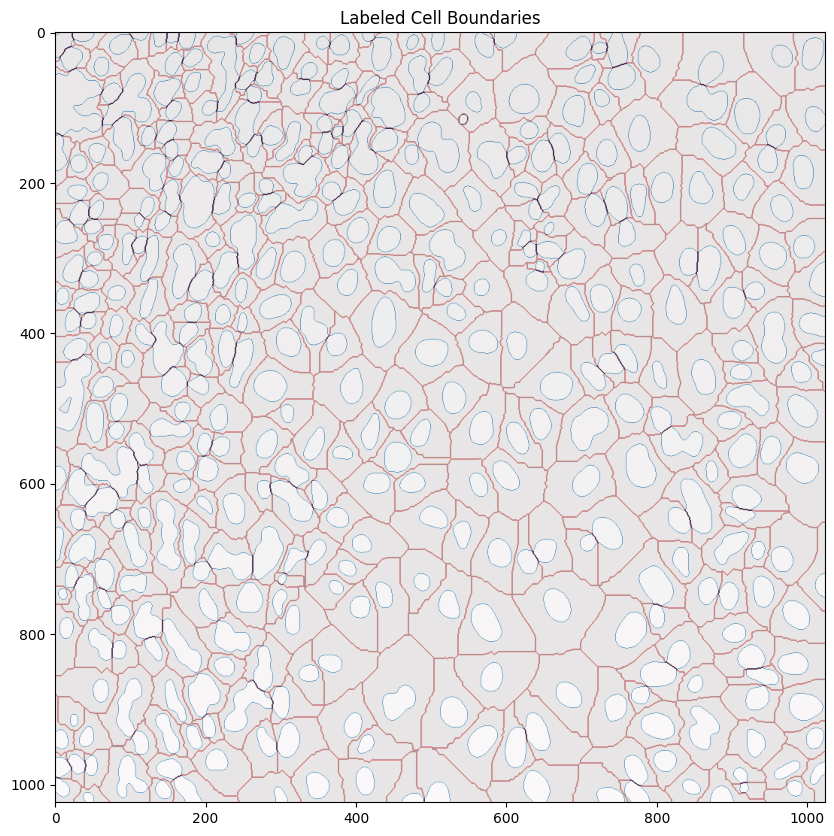

In [ ]:
nc_seg.plot_nuclei_and_cell_segmentations(labeled_nuclei_array, labeled_cells_array)

609
609


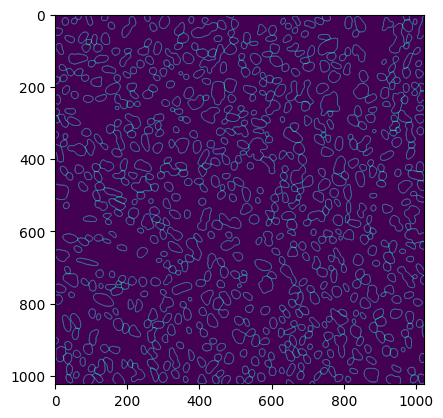

In [58]:
nuclei_boundaries = find_boundaries(labeled_nuclei_array, mode="inner")

plt.figure()
plt.imshow(nuclei_boundaries)

In [32]:
# # Get tiff images
# IMAGES_DIR = r"01_training_dataset_tif_ROIs" # Images folder
# IMAGES_LIST = os.listdir(IMAGES_DIR) # List of image file names
# IMAGES_PATHS = [os.path.join(IMAGES_DIR, image) for image in IMAGES_LIST] # Paths to images

# # Load first image
# image_0 = load_tif_image(IMAGES_PATHS[0])

# # Get JSON files
# GEOJSONS_DIR = r"01_training_dataset_geojson_nuclei"
# GEOJSONS_LIST = os.listdir(GEOJSONS_DIR) 
# GEOJSONS_PATHS = [os.path.join(GEOJSONS_DIR, image) for image in GEOJSONS_LIST] 

# # Read geojson file
# geojson_0 = load_geojson(GEOJSONS_PATHS[0])

# # Get coordinates of first entry
# coords_0_0 = get_coordinates_from_geometry(geojson_0[0])

# # Create a blank image
# image_shape = (1024, 1024)  # Adjust size as needed

# # Get binary mask for annotation types
# binary_mask_nuclei_tumor = np.zeros(image_shape, dtype=np.int32)
# binary_mask_nuclei_apoptosis = np.zeros(image_shape, dtype=np.int32)
# binary_mask_nuclei_lymphocyte = np.zeros(image_shape, dtype=np.int32)
# binary_mask_nuclei_endothelium = np.zeros(image_shape, dtype=np.int32)

# for entry in tqdm(geojson_0):
#     try:
#         coords = get_coordinates_from_geometry(entry)
#         name = entry["properties"]["classification"]["name"]
#         rr, cc = polygon(coords[:, 1], coords[:, 0], shape=image_shape)
#         if name == "nuclei_tumor":
#             # Fill the binary mask with the polygon
#             binary_mask_nuclei_tumor[rr, cc] = 1
#         elif name == "nuclei_apoptosis":
#             binary_mask_nuclei_apoptosis[rr, cc] = 1
#         elif name == "nuclei_lymphocyte":
#             binary_mask_nuclei_lymphocyte[rr, cc] = 1
#         elif name == "nuclei_endothelium":
#             binary_mask_nuclei_endothelium[rr, cc] = 1
#     except:
#         pass

# # Get binary mask
# binary_mask = \
#     combine_binary_masks(
#         binary_mask_nuclei_tumor, 
#         binary_mask_nuclei_apoptosis, 
#         binary_mask_nuclei_lymphocyte, 
#         binary_mask_nuclei_endothelium
#     )\
#         .astype(np.int32)
        
# # Get labeled nuclei
# labeled_nuclei = voronoi_otsu_labeling(binary_mask, spot_sigma=0, outline_sigma=4)

# # Get labeled cells
# labeled_cells = seeded_watershed(binary_mask, labeled_nuclei)

# # Get labeled cells as array
# labeled_cells_array = np.asarray(labeled_cells.data)

# # Find the boundaries of labeled cells
# cell_boundaries = find_boundaries(labeled_cells_array, mode='inner')

# # Plot the original binary mask
# plt.figure(figsize=(10, 10))
# plt.imshow(binary_mask, cmap="gray", alpha=0.5)  # Display the binary mask as background

# # Overlay the cell boundaries in red
# plt.imshow(cell_boundaries, cmap="Reds", alpha=0.7)

# # Optional: Add boundaries for nuclei (if needed)
# nuclei_boundaries = find_boundaries(binary_mask, mode='inner')
# plt.imshow(nuclei_boundaries, cmap="Blues", alpha=0.5)

# # Add title and remove axes
# plt.title("Labeled Cell Boundaries")
# # plt.axis("off")
# plt.show()

In [28]:
# import numpy as np
# from scipy.ndimage import distance_transform_edt

# # Compute distance map using scipy.ndimage
# def compute_distance_map(binary_image):
#     """
#     Compute the Euclidean distance map for a binary image.

#     Parameters:
#         binary_image (np.ndarray): Input binary image with 1s and 0s.

#     Returns:
#         np.ndarray: Distance map with distances to the nearest 1 for every 0 pixel.
#     """
#     # Invert the binary image (zeros become ones, and vice versa)
#     inverted_binary_image = 1 - binary_image

#     # Compute the distance transform
#     distance_map = distance_transform_edt(inverted_binary_image)

#     return distance_map

# distance_map = compute_distance_map(binary_mask)

# # Show original binary mask and distance map
# fig, axes = plt.subplots(figsize=(12, 8), nrows=1, ncols=2)
# [ax.axis('off') for ax in axes.flatten()]
# axes[0].imshow(binary_mask)
# axes[1].imshow(distance_map)
# plt.show()

In [29]:
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.feature import peak_local_max
# from skimage.segmentation import watershed
# from skimage.morphology import label
# from scipy.ndimage import distance_transform_edt

# # Step 1: Identify local maxima as markers
# local_maxi = peak_local_max(
#     distance_map, footprint=np.ones((3, 3))
# )

# # Set markers at 1 in a zeros array
# markers = np.zeros_like(distance_map)
# markers[local_maxi[:, 0], local_maxi[:, 1]] = 1

# # Step 2: Label local maxima to serve as markers for watershed
# markers = label(markers)

# # Step 3: Apply watershed algorithm
# voronoi_result = watershed(distance_map, markers, mask=binary_mask)

# # Visualization
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # Original Distance Map
# axes[0].imshow(distance_map, cmap='viridis')
# axes[0].set_title("Distance Map")
# axes[0].axis('off')

# # Voronoi Tessellation
# axes[1].imshow(voronoi_result, cmap='tab20', interpolation='none')
# axes[1].set_title("Voronoi Tessellation from Distance Map")
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()


In [30]:
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage import measure, segmentation
# from scipy.ndimage import distance_transform_edt
# from skimage.segmentation import watershed
# from skimage.feature import peak_local_max
# from skimage.measure import label

# # Step 1: Label individual cells in the binary mask
# labeled_cells = label(binary_mask)

# # Step 2: Compute the distance transform
# distance = distance_transform_edt(binary_mask)

# # Step 3: Identify local maxima as markers
# local_maxi = peak_local_max(
#     distance, footprint=np.ones((3, 3))
# )

# # Step 4: Label markers for watershed
# markers = np.zeros_like(binary_mask)
# markers[local_maxi[:, 0], local_maxi[:, 1]] = 1
# markers = label(local_maxi)
# print(markers)

# # Step 5: Apply watershed algorithm
# segmentation_result = watershed(-distance, markers, mask=binary_mask)

# # Step 6: Extract boundaries of segmented cells
# boundaries = segmentation.find_boundaries(segmentation_result, mode='inner')

# # Visualize the results
# plt.figure(figsize=(10, 10))
# plt.imshow(binary_mask, cmap="gray")  # Original binary mask
# plt.contour(boundaries, colors="red", linewidths=1)  # Solid boundaries
# plt.title("Voronoi Tessellation with Solid Cell Boundaries", fontsize=15)
# plt.axis("off")
# plt.tight_layout()
# plt.show()


In [31]:
# # def get_neighbors_indices(idx, array_shape):
    
# #     # Get possible neighbors
# #     row_idx = np.array([])
# #     col_idx = np.array([])
    
# #     for movement in [-1, 1]:
# #         row_n = idx[0] + movement
# #         col_n = idx[1] + movement
# #         if 0 <= row_n < array_shape[1]:
# #             row_idx = np.hstack([row_idx, row_n])
# #             col_idx = np.hstack([col_idx, idx[1]])
# #         if 0 <= col_n < array_shape[0]:
# #             col_idx = np.hstack([col_idx, col_n])
# #             row_idx = np.hstack([row_idx, idx[0]])
        
# #     return np.vstack([row_idx, col_idx]).T.astype(int)
# def get_neighbors_indices(idx, array_shape):
#     """
#     Get the indices of the neighbors for a given index in a 2D array.
#     """
#     row, col = idx
#     rows, cols = array_shape
#     neighbors = []

#     for dr in [-1, 0, 1]:
#         for dc in [-1, 0, 1]:
#             if dr == 0 and dc == 0:
#                 continue
#             new_row, new_col = row + dr, col + dc
#             if 0 <= new_row < rows and 0 <= new_col < cols:
#                 neighbors.append((new_row, new_col))
#     return np.array(neighbors)

# def compute_local_maxima(distance_map):
    
#     # Get indices of non-zero elements
#     nonzero_elements = np.argwhere(distance_map > 0)
    
#     # Initialize local maxima
#     local_maxima = np.zeros_like(distance_map)
#     # print(nonzero_elements[0])
    
#     # Compute whether element is local maxima or not
#     for idx in tqdm(nonzero_elements):
        
#         # Get neighbors
#         neighbors = get_neighbors_indices(idx, distance_map.shape)
        
#         # Filter neighbors with values > 0 in the distance map
#         valid_neighbors = [neighbor for neighbor in neighbors if distance_map[neighbor[0], neighbor[1]] > 0]
        
#         # Skip further computation if no valid neighbors exist
#         if not valid_neighbors:
#             continue
        
#         # Convert valid neighbors to numpy array
#         valid_neighbors = np.array(valid_neighbors)
        
#         # Get neighboring values
#         neighbor_values = distance_map[valid_neighbors[:, 0], valid_neighbors[:, 1]]
        
#         # Assign 1 if pixel is greater than all its neighbors
#         if np.count_nonzero(distance_map[idx[0], idx[1]] > neighbor_values) > (len(neighbor_values)-4):
#             local_maxima[idx[0], idx[1]] = 1
                    
#     return local_maxima

# from scipy.ndimage import binary_closing, generate_binary_structure

# # Apply morphological closing to close gaps in boundaries
# def close_gaps(binary_image):
#     """
#     Use binary closing to close gaps in detected boundaries.
#     """
#     struct = generate_binary_structure(3, 3)  # 8-connectivity
#     return binary_closing(binary_image, structure=struct)

# # def correct_local_maxima(local_maxima):
    
# #     # Get non-zero elements
# #     nonzero_elements = np.argwhere(local_maxima == 1)
    
# #     # Compute whether element is local maxima or not
# #     for idx in tqdm(nonzero_elements):
        
# #         # Get neighbors
# #         neighbors = get_neighbors_indices(idx, distance_map.shape)
        
# #         # Get neighboring values
# #         neighbor_values = distance_map[neighbors[:, 0], neighbors[:, 1]]
        
# #         # Re-assing values to zero if necessary
# #         if (np.all(idx > 0)) and (np.count_nonzero(distance_map[idx[0], idx[1]] > neighbor_values) < 2):
# #             local_maxima[idx[0], idx[1]] = 0
            
# #     return local_maxima
    

# # Compute local maxima
# local_maxima = compute_local_maxima(distance_map)

# # Correct values
# # local_maxima = correct_local_maxima(local_maxima)

# # Apply morphological closing
# # closed_maxima = close_gaps(local_maxima)

# plt.figure(figsize=(30, 16))
# plt.imshow(binary_mask, cmap='grey')
# nonzero_points = np.argwhere(local_maxima > 0)
# plt.scatter(nonzero_points[:, 1], nonzero_points[:, 0], s=0.5, color='red')